In [1]:
from preamble import *

In [2]:
#------------------------------------------------------------#
# MaxIntFilter = 33/0.514444 #knots
MaxIntFilter = 64
#------------------------------------------------------------#

In [3]:
# Load the ibtracs dataset
dataset = pd.read_csv('Data/IBTrACS/data_ibtracs_JTWC.csv')

# Apply VMAX corrections
dataset['A_VMAX'] = 0.1884 * dataset['VMAX']**1.288
dataset['VMAX2'] = 0
dataset.loc[dataset['YEAR'] < 1968, 'VMAX2'] = 0.4 * dataset['VMAX'] + 0.6 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'].between(1968,1972), 'VMAX2'] = 0.8 * dataset['VMAX'] + 0.2 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'] > 1972, 'VMAX2'] = dataset['VMAX']
dataset = dataset.drop(['VMAX','A_VMAX'], axis=1)
dataset = dataset.rename(columns={'VMAX2': 'VMAX'})

In [4]:
# Determine maximum intensity of the each cyclone
max_int = dataset.groupby('CycNo')['VMAX'].max().rename('VMAX').reset_index()

# Remove cyclones with maximum intensity lower than defined
max_int = max_int[max_int['VMAX'] >= MaxIntFilter]
dataset = dataset[dataset['CycNo'].isin(max_int['CycNo'])]

In [5]:
# Remove cyclones moved over land during its intensification
def influence(data):
    landfall = data[(data.index >= data[data['VMAX']>=MaxIntFilter].index[0]) & (data.index < (data['VMAX'].idxmax()))]
    if any(landfall['LANDFALL']==0):
        return True
    else:
        return False
    
affected_cyclones = dataset.groupby('CycNo').apply(influence).rename('affected').reset_index()
affected_cyclones = affected_cyclones[affected_cyclones['affected']==False]
dataset = dataset[dataset['CycNo'].isin(affected_cyclones['CycNo'])]

In [6]:
# Filter out cyclones which starts with typhoon intensity
affected_cyclones = dataset.groupby('CycNo').apply(lambda x: x.iloc[0]['VMAX'] > MaxIntFilter)
affected_cyclones = affected_cyclones[affected_cyclones==False].reset_index()
dataset = dataset[dataset['CycNo'].isin(affected_cyclones['CycNo'])]

In [7]:
# Filter out cyclones which has dips below threshold
def dip(data):
    landfall = data[(data.index >= data[data['VMAX']>=MaxIntFilter].index[0]) & (data.index <= (data['VMAX'].idxmax()))]
    if any(landfall['VMAX']<MaxIntFilter):
        return True
    else:
        return False

affected_cyclones = dataset.groupby('CycNo').apply(dip).rename('affected').reset_index()
affected_cyclones = affected_cyclones[affected_cyclones['affected']==False]
dataset = dataset[dataset['CycNo'].isin(affected_cyclones['CycNo'])]

### 1. Average Maximum Intensity

In [8]:
dataset['TIMESTAMP'] = pd.to_datetime('1858-11-17', format='%Y-%m-%d') + pd.to_timedelta(dataset['S_TIME'], unit='d')

In [9]:
# Determine the years in which the cyclones occured
year_occur = dataset.groupby('CycNo')['TIMESTAMP'].apply(lambda x: x.iloc[0].year).astype(int).rename('YEAR').reset_index()

In [10]:
# Determine maximum intensity of each cyclone
max_int = dataset.groupby('CycNo')['VMAX'].max().reset_index()

In [11]:
# Create a table containing metrics for each cyclones
cyclone_metrics = year_occur.merge(max_int, on ='CycNo', how='inner')

### 2. Average Intensification Rate

In [49]:
len(dataset)

31877

In [55]:
def find_long_max_cyclone(data):
    # Find the time for peak
    peak = data[data['VMAX']==data['VMAX'].max()]
    return (len(peak)>1)
        
# Determine average intensification duration
long_peak = dataset.groupby('CycNo').apply(find_long_max_cyclone)
long_peak = long_peak[long_peak == True].reset_index()

In [54]:
len(long_peak)

585

In [56]:
long_peak.head()

,CycNo,0
0,5468.0,True
1,5481.0,True
2,5490.0,True
3,5504.0,True
4,5517.0,True


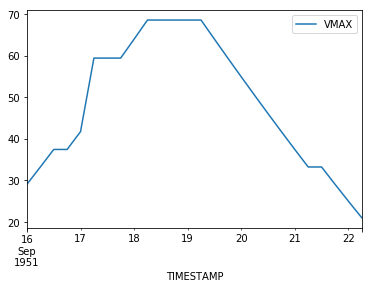

In [71]:
test = dataset[dataset['CycNo']==5504]
test.plot('TIMESTAMP','VMAX')
plt.show()

In [ ]:
def inter_peak(data):

In [15]:
def growth_curve(data):
    # Normalise VMAX
    max_speed = data['VMAX'].max()
    data_select = data[(data['VMAX'] >= MaxIntFilter) & (data['VMAX'] <= max_speed)][['S_TIME','VMAX']]
    data_select['VMAX_n'] = data_select['VMAX']/max_speed

    # Calculate time to peak intesity
    time_peak = data['S_TIME'][data['VMAX'].idxmax()]
    data_select['time_n'] = data_select['S_TIME'] - time_peak
    return data_select

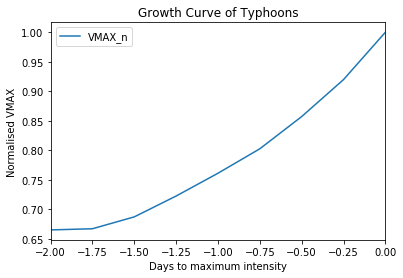

In [70]:
growth = dataset.groupby('CycNo').apply(growth_curve).reset_index()
growth_average = growth.groupby('time_n')['VMAX_n'].mean().reset_index()

growth_average[growth_average['time_n'].between(-2,0)].plot('time_n','VMAX_n')
plt.title('Growth Curve of Typhoons')
plt.ylabel('Normalised VMAX')
plt.xlabel('Days to maximum intensity')
plt.show()

In [ ]:
growth

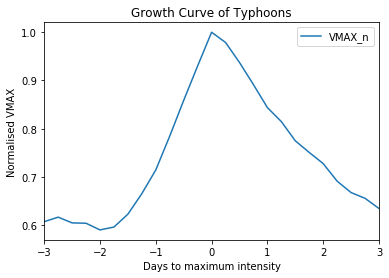

In [17]:
# Remove cyclones with maximum intensity lower than defined
strong_int = max_int[max_int['VMAX'] >= 137]
strong_typ = dataset[dataset['CycNo'].isin(strong_int['CycNo'])]

growth = strong_typ.groupby('CycNo').apply(growth_curve).reset_index()
growth_average = growth.groupby('time_n')['VMAX_n'].mean().reset_index()

growth_average[growth_average['time_n'].between(-3,3)].plot('time_n','VMAX_n')
plt.title('Growth Curve of Typhoons')
plt.ylabel('Normalised VMAX')
plt.xlabel('Days to maximum intensity')
plt.show()

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
test.head()

,BASIN,CycNo,DIST2LAND,GENESIS,LANDFALL,LAT,LON,S_TIME,YEAR,VMAX,TIMESTAMP
0,2.0,5453.0,1943.0,2.0,1943.0,8.6,167.999996,33725.00,1951.0,46.054183,1951-03-20 00:00:00
1,2.0,5453.0,2018.0,2.0,2018.0,8.5,168.799996,33725.25,1951.0,54.897904,1951-03-20 06:00:00
2,2.0,5453.0,2085.0,2.0,2085.0,8.5,169.499996,33725.50,1951.0,63.945675,1951-03-20 12:00:00
3,2.0,5453.0,2135.0,2.0,2135.0,8.5,170.099996,33725.75,1951.0,68.540112,1951-03-20 18:00:00
4,2.0,5453.0,2198.0,2.0,2198.0,8.6,170.799996,33726.00,1951.0,73.178898,1951-03-21 00:00:00


In [20]:
def int_rate(data):
    data = data[(data.index >= data[data['VMAX']>=MaxIntFilter].index[0]-1) & (data.index <= (data['VMAX'].idxmax()+1))]
    X_train = data[['S_TIME']].values
    y_train = data['VMAX'].values

    lr = LinearRegression().fit(X_train, y_train)

    return lr.coef_[0]/4

# Calculate average intensification rate
ave_int_rate = dataset.groupby('CycNo').apply(int_rate).rename('Intensification Rate').reset_index()

In [21]:
# List cyclones with invalid intensification rate
invalid_cyclone = ave_int_rate[ave_int_rate.isnull().any(axis=1)]['CycNo'].values
invalid_cyclone

array([], dtype=float64)

In [22]:
cyclone_metrics = cyclone_metrics.merge(ave_int_rate, on ='CycNo', how='inner')

### 3. Average Intensification Duration

In [23]:
def duration(data):
    # Find the time for peak
    time_peak = data['S_TIME'][data['VMAX'].idxmax()]

    # Select the 2 points between the start of intensification
    start_data = data[(data.index >= data[data['VMAX']>=MaxIntFilter].index[0]-1) & (data.index <= data[data['VMAX']>=MaxIntFilter].index[0])]

    # Find the time for intensification start 
    time_start = np.interp(MaxIntFilter, start_data['VMAX'], start_data['S_TIME'])
    
    dur = time_peak-time_start
    
    return dur
        
# Determine average intensification duration
int_duration = dataset.groupby('CycNo').apply(duration).rename('Intensification Duration').reset_index()
    

In [24]:
# List cyclones with invalid intensification duration
int_duration[int_duration['Intensification Duration'] == 0]['CycNo'].values

array([], dtype=float64)

In [25]:
cyclone_metrics = cyclone_metrics.merge(int_duration, on ='CycNo', how='inner')

### 4. Data Analysis

In [26]:
# Removal of invalid cyclones
cyclone_metrics = cyclone_metrics[~cyclone_metrics['CycNo'].isin(invalid_cyclone)]

In [27]:
cyclone_metrics.head()

,CycNo,YEAR,VMAX,Intensification Rate,Intensification Duration
0,5453.0,1951,101.853956,6.078194,1.247044
1,5459.0,1951,131.785661,9.813484,1.498529
2,5468.0,1951,82.582599,6.995326,0.497044
3,5481.0,1951,101.853956,3.654885,2.497044
4,5490.0,1951,82.582599,2.611861,1.497044


In [28]:
# Calculate annual mean of cyclone metrics
metrics = ['VMAX','Intensification Rate','Intensification Duration']
annual_cyclone_metrics = cyclone_metrics.groupby(['YEAR'])[metrics].mean().reset_index()

# Convert data to m/s
annual_cyclone_metrics['VMAX'] = annual_cyclone_metrics['VMAX']*0.514444
annual_cyclone_metrics['Intensification Rate'] = annual_cyclone_metrics['Intensification Rate']*0.514444

# Creat TIME column for plotting
annual_cyclone_metrics['TIME'] = pd.to_datetime(annual_cyclone_metrics['YEAR'], format='%Y')

In [29]:
# Calculate decadal mean for maximum intensity
rolling = annual_cyclone_metrics
rolling = rolling.set_index('TIME')

rolling = rolling.rolling(min_periods=9, window=9, center=True)[metrics].mean().reset_index()
rolling.columns = ['TIME', '9-year average VMAX', '9-year average Int Rate', '9-year average Int Duration']

# Merge with original cyclone metrics dataframe
annual_cyclone_metrics = annual_cyclone_metrics.merge(rolling, on ='TIME', how='inner')

### Average Maximum Intensity Plot

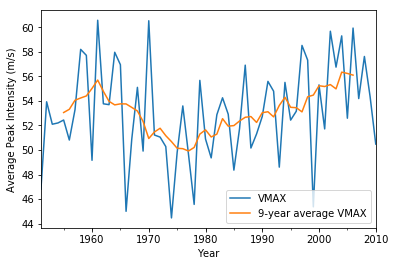

In [30]:
ax = annual_cyclone_metrics.plot('TIME', ['VMAX','9-year average VMAX'])
plt.ylabel('Average Peak Intensity (m/s)')
plt.xlabel('Year')
plt.show()

### Average Intensification Rate Plot

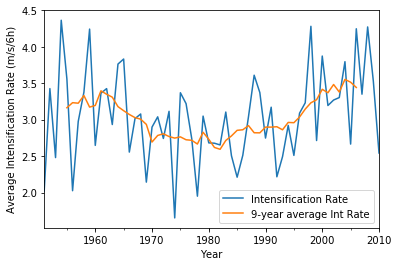

In [31]:
ax = annual_cyclone_metrics.plot('TIME', ['Intensification Rate','9-year average Int Rate'])
plt.ylabel('Average Intensification Rate (m/s/6h)')
plt.xlabel('Year')
plt.show()

### Average Intensification Duration Plot

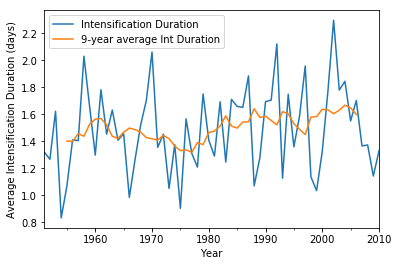

In [32]:
ax = annual_cyclone_metrics.plot('TIME', ['Intensification Duration','9-year average Int Duration'])
plt.ylabel('Average Intensification Duration (days)')
plt.xlabel('Year')
plt.show()

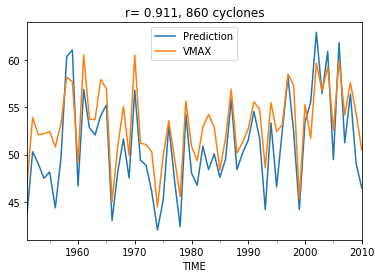

In [33]:
annual_cyclone_metrics['Prediction'] = annual_cyclone_metrics['Intensification Duration']*annual_cyclone_metrics['Intensification Rate']*4 + MaxIntFilter*0.514444
ax = annual_cyclone_metrics.plot('TIME','Prediction')
annual_cyclone_metrics.plot('TIME','VMAX',ax=ax)
plt.title('r= {:.3f}, {} cyclones'.format(np.corrcoef(annual_cyclone_metrics['Prediction'], annual_cyclone_metrics['VMAX'])[0][1],cyclone_metrics['CycNo'].nunique()))
plt.show()

In [34]:
print('Duration-Rate correlation: {:.3f}'.format(np.corrcoef(annual_cyclone_metrics['Intensification Rate'],annual_cyclone_metrics['Intensification Duration'])[0][1]))

Duration-Rate correlation: -0.089


In [39]:
# annual_cyclone_metrics[['YEAR','Intensification Rate', '9-year average Int Rate']].to_csv('Data/Computed-Data/computed_annual-intensification-rate_JTWC.csv',index=False)

In [40]:
# annual_cyclone_metrics[['YEAR','Intensification Duration', '9-year average Int Duration']].to_csv('Data/Computed-Data/computed_annual-intensification-duration_JTWC.csv',index=False)

In [41]:
# annual_cyclone_metrics[['YEAR','VMAX', '9-year average VMAX']].to_csv('Data/Computed-Data/computed_annual-max-intensity_JTWC.csv',index=False)

In [42]:
# cyclone_metrics.to_csv('Data/Computed-Data/computed_cyclone-metrics_JTWC.csv',index=False)